# Tech Challenge - Fase 1

## Análise e previsão de despesas médicas

O conjunto de dados de seguro médico abrange vários fatores que influenciam as despesas médicas, como idade, sexo, IMC, tabagismo, número de filhos e região. Este conjunto de dados serve de base para o treinamento de modelos de aprendizado de máquina capazes de prever despesas médicas para novos segurados.


# Itens abordados:

* 1 - Análise exploratória dos dados
* 2 - Regressao linear simples
* 3 - DecisionTreeRegressor
* 4 - RandomForestRegressor




# Base de dados

- A base de dados foi obtida do kaggle.com https://www.kaggle.com/datasets/rahulvyasm/medical-insurance-cost-prediction?resource=download :


- **2772** registros
- Não há registros vazios
- **1435** linhas duplicadas
- Após a remoção das linhas duplicas **1337** linhas


# Atributos:

- **age**: idade

- **sex**: Sexo

- **bmi**: indice de massa corporal

- **children**: número de filhos

- **smoker**: fumante

- **region**: região

- **charges**: gasto com o plano de saúde

# 1 - Análise exploratória dos dados

**Import necessários para execução**

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

Necessário fazer o upload .csv

In [2]:
import pandas as pd

def initialize_database():
  dados = pd.read_csv("insurance.csv")
  #dados = pd.read_csv("medical_insurance.csv") # base do kaggle
  print("base de dados inicializada...")
  return dados


In [3]:
dados = initialize_database()

upsampling = False

base de dados inicializada...


In [4]:
dados.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
dados.shape

(1338, 7)

In [6]:
dados.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [7]:
dados

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


# Registros duplicados

**Obs**: Não estou removendo os duplicados

In [20]:
def list_duplicated(dados):
  duplicados = dados.duplicated()
  numero_duplicados = duplicados.sum()
  print(f"Número de registros duplicados: {numero_duplicados}")

  linhas_duplicadas = dados[duplicados]
  print(linhas_duplicadas)

def remove_duplicated(dados):
  # Removendo duplicados (por padrão, mantém a primeira linha)
  dados = dados.drop_duplicates()

  # reindexando a base de dados
  dados.reset_index(drop=True)
  return dados;

* Listando os registros duplicados da base de dados




In [58]:
list_duplicated(dados)

Número de registros duplicados: 1
     age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631


- removendo os registros duplicados

In [59]:
print(dados.shape)

dados = remove_duplicated(dados)

print(dados.shape)

(1338, 7)
(1337, 7)


# Exploração dos dados

In [33]:
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [46]:
dados.describe().T

AttributeError: 'NoneType' object has no attribute 'describe'

In [29]:
dados.groupby('sex').describe()

age                                                         bmi  \
        count       mean        std   min   25%   50%    75%   max  count   
sex                                                                         
female  662.0  39.503021  14.054223  18.0  27.0  40.0  51.75  64.0  662.0   
male    675.0  38.946667  14.039584  18.0  26.0  39.0  51.00  64.0  675.0   

                   ... children      charges                              \
             mean  ...      75%  max   count          mean           std   
sex                ...                                                     
female  30.377749  ...      2.0  5.0   662.0  12569.578844  11128.703801   
male    30.943652  ...      2.0  5.0   675.0  13974.998864  12971.958663   

                                                                      
              min          25%        50%           75%          max  
sex                                                                   
female  1607.5101  4885.158700  9412.9625  14454.691825  63770.42801  
male    1121.8739  4654.022675  9377.9047  19006.685500  62592.87309  

[2 rows x 32 columns]

In [ ]:
dados.groupby('smoker').describe()

age                                                          bmi  \
         count       mean        std   min    25%   50%   75%   max   count   
smoker                                                                        
no      1064.0  39.385338  14.083410  18.0  26.75  40.0  52.0  64.0  1064.0   
yes      274.0  38.514599  13.923186  18.0  27.00  38.0  49.0  64.0   274.0   

                   ... children      charges                              \
             mean  ...      75%  max   count          mean           std   
smoker             ...                                                     
no      30.651795  ...      2.0  5.0  1064.0   8434.268298   5993.781819   
yes     30.708449  ...      2.0  5.0   274.0  32050.231832  11541.547176   

                                                                          
               min           25%          50%           75%          max  
smoker                                                                    
no       1121.8739   3986.438700   7345.40530  11362.887050  36910.60803  
yes     12829.4551  20826.244213  34456.34845  41019.207275  63770.42801  

[2 rows x 32 columns]

In [ ]:
dados.groupby('region').describe()

age                                                         bmi  \
           count       mean        std   min    25%   50%   75%   max  count   
region                                                                         
northeast  324.0  39.268519  14.069007  18.0  27.00  39.5  51.0  64.0  324.0   
northwest  325.0  39.196923  14.051646  19.0  26.00  39.0  51.0  64.0  325.0   
southeast  364.0  38.939560  14.164585  18.0  26.75  39.0  51.0  64.0  364.0   
southwest  325.0  39.455385  13.959886  19.0  27.00  39.0  51.0  64.0  325.0   

                      ... children      charges                              \
                mean  ...      75%  max   count          mean           std   
region                ...                                                     
northeast  29.173503  ...      2.0  5.0   324.0  13406.384516  11255.803066   
northwest  29.199785  ...      2.0  5.0   325.0  12417.575374  11072.276928   
southeast  33.355989  ...      2.0  5.0   364.0  14735.411438  13971.098589   
southwest  30.596615  ...      2.0  5.0   325.0  12346.937377  11557.179101   

                                                                          
                 min          25%           50%         75%          max  
region                                                                    
northeast  1694.7964  5194.322288  10057.652025  16687.3641  58571.07448  
northwest  1621.3402  4719.736550   8965.795750  14711.7438  60021.39897  
southeast  1121.8739  4440.886200   9294.131950  19526.2869  63770.42801  
southwest  1241.5650  4751.070000   8798.593000  13462.5200  52590.82939  

[4 rows x 32 columns]

In [ ]:
dados.groupby('children').describe()

age                                                         bmi  \
          count       mean        std   min    25%   50%   75%   max  count   
children                                                                      
0         574.0  38.444251  16.436228  18.0  22.00  36.0  55.0  64.0  574.0   
1         324.0  39.453704  12.067445  18.0  30.00  40.0  49.0  64.0  324.0   
2         240.0  39.445833  11.588715  18.0  30.00  40.0  48.0  64.0  240.0   
3         157.0  41.566879  12.206174  18.0  31.00  41.0  52.0  64.0  157.0   
4          25.0  39.000000  12.138094  18.0  29.00  39.0  48.0  61.0   25.0   
5          18.0  35.611111  10.123583  19.0  28.75  39.0  42.5  52.0   18.0   

                     ...                  charges                              \
               mean  ...       75%    max   count          mean           std   
children             ...                                                        
0         30.550296  ...  34.74625  53.13   574.0  12365.975602  12023.293942   
1         30.623148  ...  34.23750  52.58   324.0  12731.171832  11823.631451   
2         30.978104  ...  35.35750  48.07   240.0  15073.563734  12891.368347   
3         30.684331  ...  34.32000  46.53   157.0  15355.318367  12330.869484   
4         31.391200  ...  33.66000  41.47    25.0  13850.656311   9139.223321   
5         29.605000  ...  33.05500  46.75    18.0   8786.035247   3808.435525   

                                                                          
                min          25%          50%           75%          max  
children                                                                  
0         1121.8739  2734.421150   9856.95190  14440.123825  63770.42801  
1         1711.0268  4791.643175   8483.87015  15632.052050  58571.07448  
2         2304.0022  6284.939438   9264.97915  20379.276748  49577.66240  
3         3443.0640  6652.528800  10600.54830  19199.944000  60021.39897  
4         4504.6624  7512.267000  11033.66170  17128.426080  40182.24600  
5         4687.7970  5874.973900   8589.56505  10019.943975  19023.26000  

[6 rows x 24 columns]

<Axes: xlabel='age', ylabel='Count'>

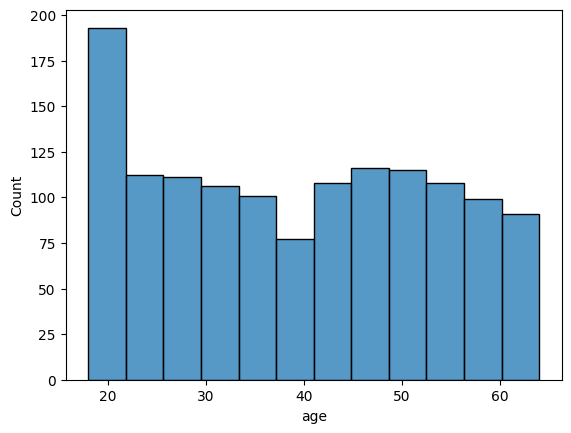

In [34]:
sb.histplot(data=dados, x="age")

<Axes: xlabel='children', ylabel='Count'>

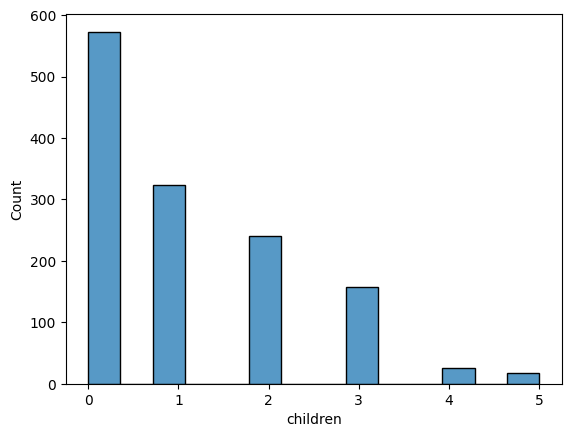

In [35]:
sb.histplot(data=dados, x="children")

<Axes: xlabel='bmi', ylabel='Count'>

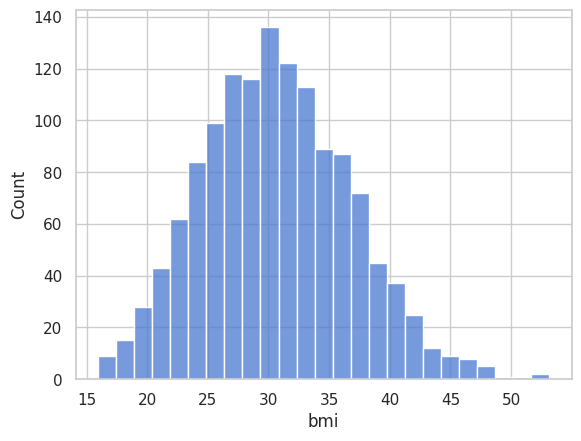

In [ ]:
sb.histplot(data=dados, x="bmi")

<Axes: ylabel='charges'>

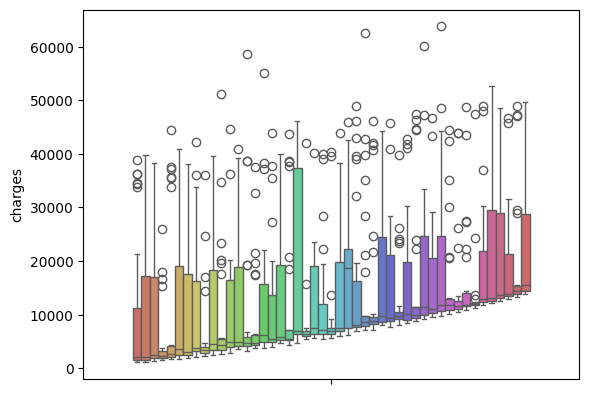

In [38]:
sb.boxplot(hue='age', y='charges', data=dados, palette='hls', legend=False)

**Obs:** Pode ser observado nesse gráfico, a relação da idade e dos gastos, que com o avanço da idade os gastos vão aumentando....

<Axes: xlabel='smoker', ylabel='charges'>

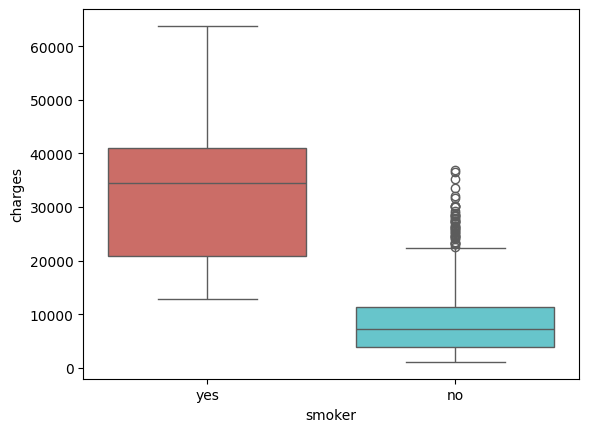

In [39]:
sb.boxplot(x='smoker', y='charges', hue='smoker', data=dados, palette='hls', legend=False)

**Obs:** Nesse gráfico pode ser observado que o fumante tem um gasto maior, em relação ao não fumante.

<Axes: xlabel='sex', ylabel='charges'>

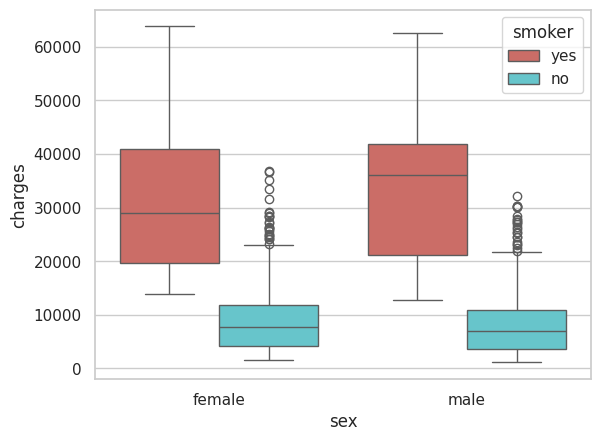

In [ ]:

sb.boxplot(x='sex', y='charges', hue='smoker', data=dados, palette='hls', legend=True)

<Axes: xlabel='charges'>

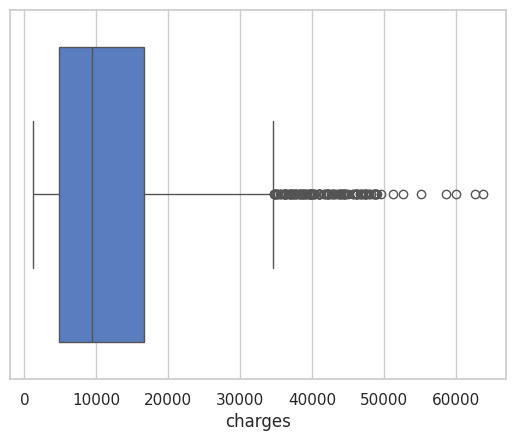

In [ ]:
sb.boxplot(x=dados["charges"])

<Axes: xlabel='bmi'>

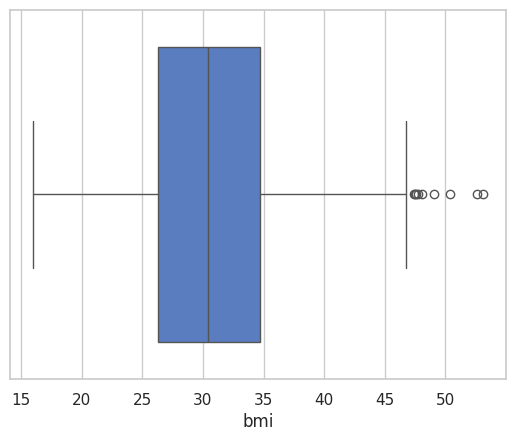

In [ ]:
sb.boxplot(x=dados["bmi"])

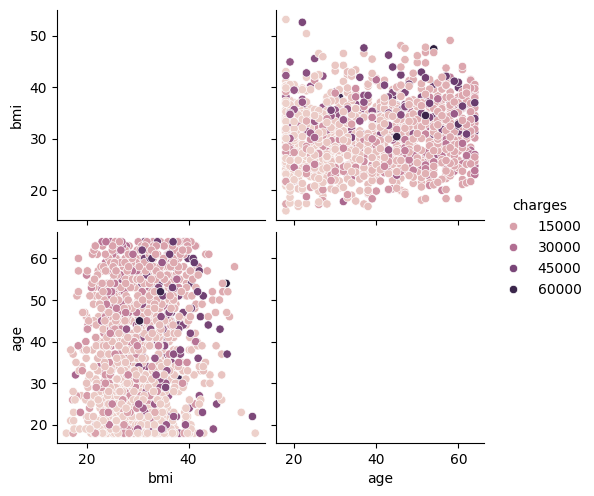

In [40]:
sb.pairplot(dados,vars=['bmi','age'],hue="charges")

**Obs:** Nesses gráficos, pode ser observar que quanto maior o bmi (indice de massa corportal) maior o gasto com o plano de saúde, o mesmo com  avanço da idade.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 20.0% of the points cannot be plac

[Text(13.000000000000002, 0.5, '')]

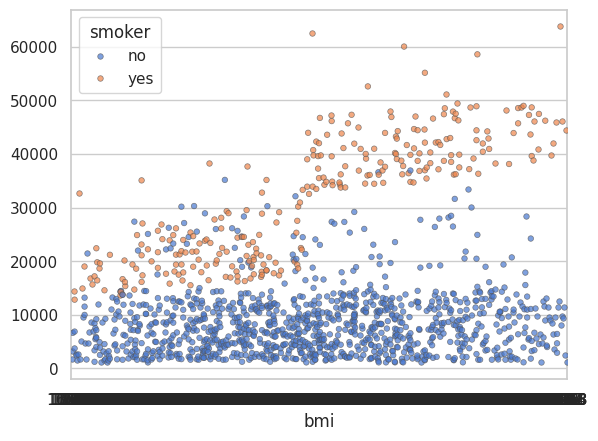

In [ ]:
sb.set_theme(style="whitegrid", palette="muted")
ax = sb.swarmplot(data=dados, x="bmi", y="charges", hue="smoker",   size=4, linewidth=0.5,  alpha=0.7)
ax.set(ylabel="")

**Obs:** Aqui neste gráfico (smoker, bmi e charges), pode perceber que fumantes tem mais gastos com o plano de saude e quanto mais alto IMC o gasto vai aumentando


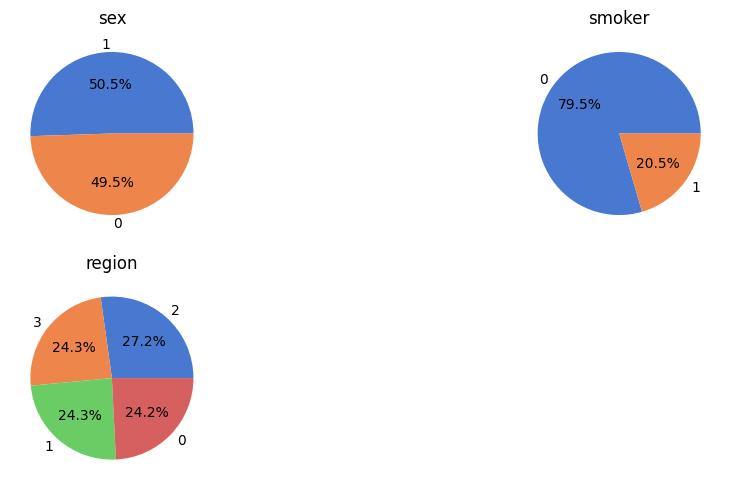

In [ ]:
plt.figure(figsize=(12,9))
for i,col in enumerate(['sex','smoker','region']):
    plt.subplot(3,2,i+1)
    x=dados[col].value_counts().reset_index()
    plt.title(col)
    plt.pie(x=x['count'],labels=x[col],autopct="%0.1f%%",colors=sns.color_palette('muted'))

# 1.1 - LabelEncoder

Vamos utilizar **label enconder** para tratar variáveis categóricas: **sex, smoker e region**

In [8]:
from sklearn.preprocessing import LabelEncoder

def encoded_labels(dados):
  colunas=['sex','smoker','region']
  print("encoded_labels:", colunas )

  label_encoder = LabelEncoder()
  for col in colunas:
    dados[col] = label_encoder.fit_transform(dados[col])

  return dados

In [9]:
dados = encoded_labels(dados)

dados.head()

encoded_labels: ['sex', 'smoker', 'region']


,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


# 1.2 - Categorizando BMI

**`O índice de massa corporal ( IMC )`** é um valor derivado da massa ( peso ) e altura de uma pessoa. O IMC é definido como a massa corporal dividida pelo quadrado da altura corporal e é expresso em unidades de kg/m 2




IMC, categorias básicas Categoria	IMC (kg/m 2 )
- Abaixo do peso (magreza severa):	< 16,0
- Abaixo do peso (magreza moderada):	16,0 – 16,9
- Abaixo do peso (magreza leve):	17,0 – 18,4
- Intervalo normal:	18,5 – 24,9
- Excesso de peso (pré-obeso):	25,0 – 29,9
- Obeso (Classe I):	30,0 – 34,9
- Obeso (Classe II):	35,0 – 39,9
- Obeso (Classe III):	≥ 40,0

In [10]:
def category_bmi(dados):
  print("categorizando a coluna bmi...")
  #dados.loc[:,"bmi-types"] = pd.cut(dados["bmi"],
  dados["bmi-types"] = pd.cut(dados["bmi"],
                        bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, np.inf],
                        labels=[1, 2, 3, 4, 5, 6]).cat.codes

  dados = dados.drop(columns = [ "bmi"]).copy()

  #dados.reset_index(drop=True)

  return dados

In [11]:
dados = category_bmi(dados)
dados['bmi-types']

categorizando a coluna bmi...


0       2
1       3
2       3
3       1
4       2
       ..
1333    3
1334    3
1335    4
1336    2
1337    2
Name: bmi-types, Length: 1338, dtype: int8

In [12]:
print(dados)

      age  sex  children  smoker  region      charges  bmi-types
0      19    0         0       1       3  16884.92400          2
1      18    1         1       0       2   1725.55230          3
2      28    1         3       0       2   4449.46200          3
3      33    1         0       0       1  21984.47061          1
4      32    1         0       0       1   3866.85520          2
...   ...  ...       ...     ...     ...          ...        ...
1333   50    1         3       0       1  10600.54830          3
1334   18    0         0       0       0   2205.98080          3
1335   18    0         0       0       2   1629.83350          4
1336   21    0         0       0       3   2007.94500          2
1337   61    0         0       1       1  29141.36030          2

[1338 rows x 7 columns]


# 1.4 - Upsampling

**Upsampling** é uma técnica de manipulação de dados usada para resolver o desequilíbrio de classes em conjuntos de dados, mas é importante considerar suas limitações, como **Overfitting**

In [29]:
def run_upsampling(dados):
  dados = dados.sample(n=5000, replace=True, random_state=42, ignore_index=True)
  return dados

In [32]:
dados = run_upsampling(dados)

dados.shape
upsampling = True

# 1.5 - Exploração de dados após ajustes

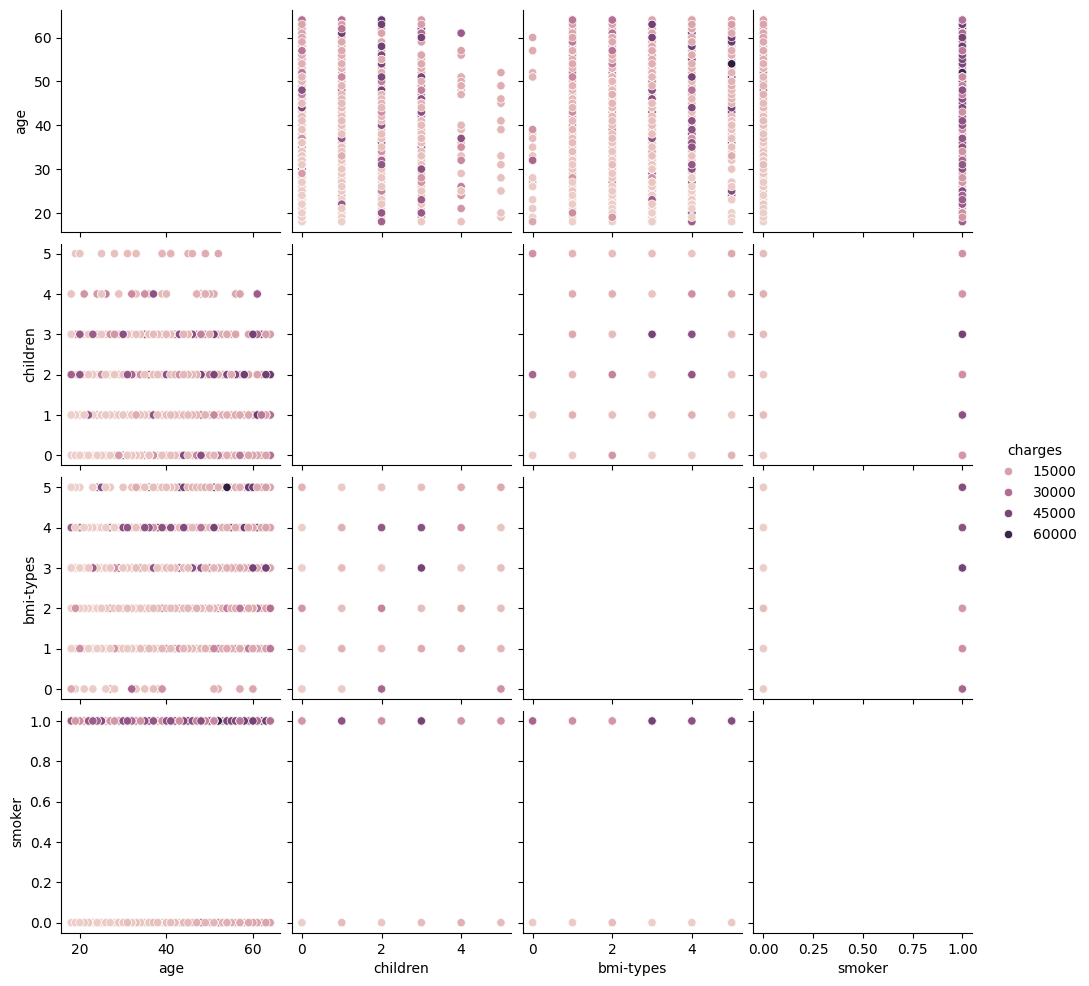

In [ ]:
sb.pairplot(dados,vars=['age','children','bmi-types','smoker'],hue="charges")


# 1.6 - Correlações

<Axes: >

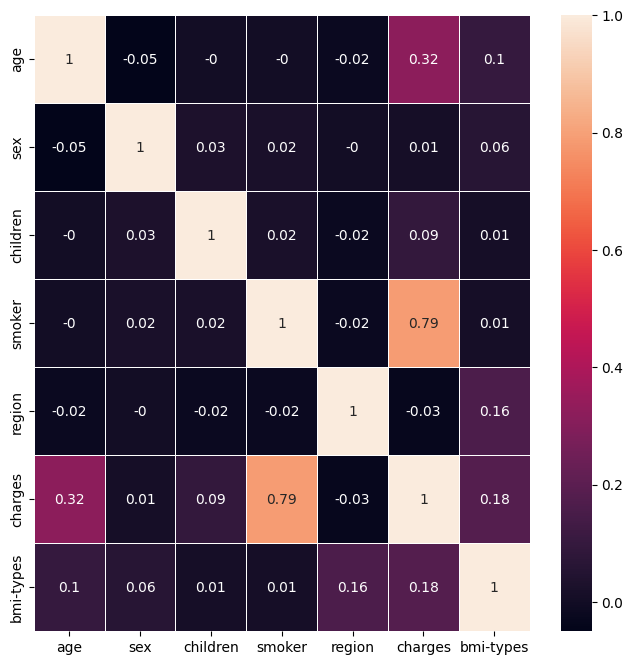

In [92]:
correlation_matrix = dados.corr().round(2)
fig, ax = plt.subplots(figsize=(8,8))
sb.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)

**obs:** pode ser percebido que a correlação dos gastos com a pessoa fumante é alta de 0,79 e com bmi de 0,20 e de idade 0,32

In [ ]:
correlation_matrix = dados.corr()
max_corr = correlation_matrix.stack().sort_values(ascending=False).drop_duplicates()
max_corr = max_corr[max_corr < 1].head(10)

print("Maiores correlações:")
print(max_corr)

Maiores correlações:
smoker     charges      0.788153
age        charges      0.321103
bmi-types  charges      0.196639
           region       0.133129
           age          0.114130
children   charges      0.082119
smoker     sex          0.058125
sex        bmi-types    0.054603
           charges      0.041237
age        children     0.033065
dtype: float64


# Bases de treino e teste

- função para estratificação da base de treinamento e teste do modelo

In [ ]:
def define_x_y():
  y = dados['charges']
  X = dados[['age', 'sex', 'smoker', 'region', 'children', 'bmi-types']]
  return X, y

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

def process_split_train_test(X, y, is_shuffle=True):

    if is_shuffle:
      print("Usando o ShuffleSplit em bmi-types")
      split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
      for train_index, test_index in split.split(X, X["bmi-types"]):
          shuffe_train = dados.loc[train_index]
          shuffe_test = dados.loc[test_index]

 #     print("% base de treino -------------------")
 #     print(shuffe_train["bmi-types"].value_counts() / len(shuffe_train))

 #     print("% base de teste ---------------------")
 #     print(shuffe_test["bmi-types"].value_counts() / len(shuffe_test))

 #     print("removendo coluna bmi-types")
      for set_ in (shuffe_train, shuffe_test):
        set_.drop("bmi-types", axis=1, inplace=True)

      X_train = shuffe_train.copy()
      y_train = X_train['charges'].copy()

      X_train = X_train.drop(columns=['charges'], axis=1)

      X_test = shuffe_test.copy()
      y_test = X_test['charges'].copy()

      X_test = X_test.drop(columns=['charges'], axis=1)
    else:
      print("Não usando o ShuffleSplit")
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, y_train, X_test, y_test

- função de avaliação do modelo

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def avalia_modelo(model, X_train, y_train, X_test, y_test, y_predito):
  print("Avaliando o desempenho do modelo")
  mse = mean_squared_error(y_test, y_predito)

  mae = mean_absolute_error(y_test, y_predito)
  r2 = r2_score(y_test, y_predito)

  print("mse - Mean Squared Error :", mse)
  print("mae - Mean Absolute Error:", mae)
  print("r2  - R-squared          :", r2)

#  print()
#  print("O score nos dá uma visão da precisão média da floresta aleatória nos dados")
#  print("score train: ", model.score(X_train, y_train))
#  print("score test : ", model.score(X_test, y_test))

  score_std, score_mean = validacao_cruzada(model)

  return {'model': model.__class__.__name__,
                    'shuffle_split': shuffle_split,
                    'upsampling': upsampling,
                    'mae': mae.round(2),
                    'mse': mse.round(2),
                    'r2': r2.round(4),
                    'k-fold std': score_std,
                    'k-fold mean': score_mean  }

#  novo_df = pd.DataFrame([novo_resultado])

#  df_results = pd.concat([df_results, novo_df], ignore_index=True)

#  results.append({
#        'model': model.__class__.__name__,
#        'mae': mae.round(2),
#        'mse': mse.round(2),
#        'r2': r2.round(4),
#        'k-fold std':  score_std,
#        'k-fold mean': score_mean
 # })

- função de validação cruzada

In [15]:
from sklearn.model_selection import KFold, cross_val_score

def validacao_cruzada(model, k=10):
  print("")
  print("Validação cruzada k:", k)

  # Realize a validação cruzada e armazene os resultados em 'scores'
  scores = cross_val_score(model, X, y, cv=KFold(n_splits=k, shuffle=True, random_state=42))

  # Imprima a média e o desvio padrão das métricas
#  print("K-Fold (R^2) Scores: {0}".format(scores))
  print("Desvio padrão do R²:", scores.std())
  print("Média do R²:", scores.mean())
  return scores.std(), scores.mean()

In [16]:
def plt_real_previsto(y_test, predictions, model):
  plt.scatter(y_test, predictions)
  plt.xlabel('Encargo Real')
  plt.ylabel('Encargo Previsto')

  plt.title('Real vs Previsto - ' + model.__class__.__name__)

  ideal_values = np.linspace(min(y_test), max(y_test))
  plt.plot(ideal_values, ideal_values, color='red', label='Ideal')
  plt.legend()
  plt.show()


# 2 - Regressao linear simples - - - - - - - - - - - - - - - - - - -


In [17]:
df_results = pd.DataFrame();
print(df_results.shape)

(0, 0)


In [20]:
from sklearn.linear_model import LinearRegression

def linear_regression():
  # Criando um modelo de regressão linear
  model = LinearRegression()

  # Treinando o modelo
  model.fit(X_train, y_train)

  # Fazendo previsões nos dados de teste
  y_pred = model.predict(X_test)
  return model, y_pred


**Run model linear regression**

In [33]:
X, y = define_x_y()

shuffle_split = True

X_train, y_train, X_test, y_test = process_split_train_test(X, y, shuffle_split)

model, y_pred = linear_regression()

avaliacao = avalia_modelo(model, X_train, y_train, X_test, y_test, y_pred)

df = pd.DataFrame([avaliacao])
df_results = pd.concat([df_results, df], ignore_index=True)
df_results.head(20)


Usando o ShuffleSplit em bmi-types
Avaliando o desempenho do modelo
mse - Mean Squared Error : 42911644.31913762
mae - Mean Absolute Error: 4268.502889304533
r2  - R-squared          : 0.7096596990930092

Validação cruzada k: 10
Desvio padrão do R²: 0.018778279909592643
Média do R²: 0.7416884872589607


,model,shuffle_split,upsampling,mae,mse,r2,k-fold std,k-fold mean
0,LinearRegression,False,False,4227.17,33916490.24,0.7815,0.057830,0.741254
1,DecisionTreeRegressor,True,False,3907.51,62678520.26,0.5845,0.046627,0.690190
2,DecisionTreeRegressor,False,False,3033.43,41847506.77,0.7304,0.046627,0.690190
3,RandomForestRegressor,False,False,2714.11,23108199.85,0.8512,0.040176,0.816638
4,RandomForestRegressor,True,False,4009.63,48655608.13,0.6774,0.040176,0.816638
5,LinearRegression,True,False,4100.91,42149780.10,0.7206,0.057830,0.741254
6,LinearRegression,True,False,4220.50,43254922.74,0.7271,0.018661,0.750707
7,LinearRegression,True,True,4268.50,42911644.32,0.7097,0.018778,0.741688


**Resultado**

Com o modelo  **LinearRegression** , usamos a primeiro a informação 'bmi' sem fazer a categorização que obteve um resultado de **73,98%**. Após fizemos uma categorização na coluna 'bmi' que obtivemos um resultado de **74,08%.** E depois usamos a técnica de ShuffleSplit para treinar o modelo nas faixas de BMI, onde tem uma melhora nos resultados **77,47%**

| bmi categories | ShuffleSplit | R-squared |
|---|---|---|
| Não | Não | 0.7398 |
| Sim | Não | 0.7408 |
| Sim | Sim | 0.7747 |


# Visualizando previsões

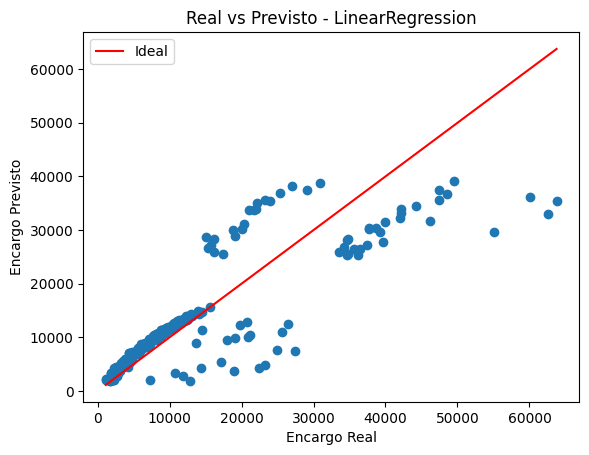

In [ ]:
plt_real_previsto(y_test, y_pred, model)

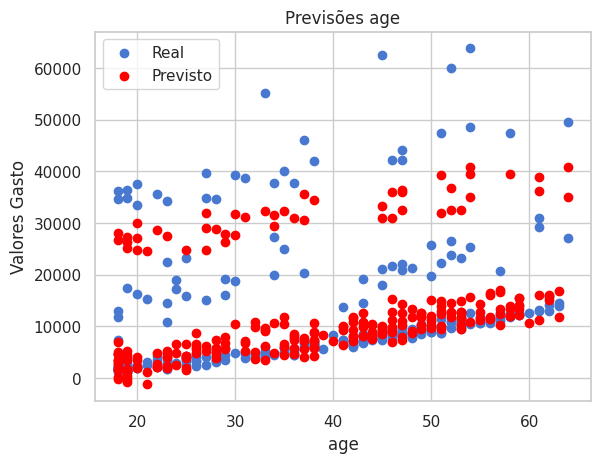

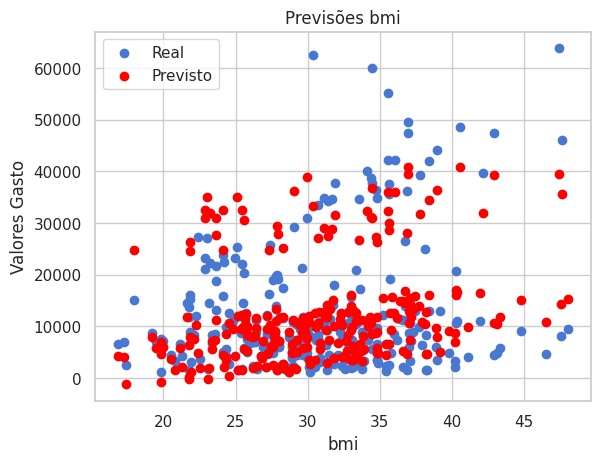

In [ ]:

feature = 'age'

plt.scatter(X_test[feature], y_test, label='Real')
plt.scatter(X_test[feature], y_pred, label='Previsto', color='red')
plt.xlabel(feature)
plt.ylabel('Valores Gasto')
plt.title('Previsões age')
plt.legend()
plt.show()

feature = 'bmi'

plt.scatter(X_test[feature], y_test, label='Real')
plt.scatter(X_test[feature], y_pred, label='Previsto', color='red')
plt.xlabel(feature)
plt.ylabel('Valores Gasto')
plt.title('Previsões bmi')
plt.legend()
plt.show()

# 3 - Modelo baseado em árvore (DecisionTreeRegressor) - - - - - - - - - - - -



In [22]:
from sklearn.tree import DecisionTreeRegressor

def decision_tree_regressor():
  model = DecisionTreeRegressor(random_state=42)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  return model, y_pred

**Run model decision_tree_regressor**

In [34]:
X, y = define_x_y()

shuffle_split = True

X_train, y_train, X_test, y_test = process_split_train_test(X, y, shuffle_split)

model, y_pred = decision_tree_regressor()

avaliacao = avalia_modelo(model, X_train, y_train, X_test, y_test, y_pred)

df = pd.DataFrame([avaliacao])
df_results = pd.concat([df_results, df], ignore_index=True)
df_results.head(20)


Usando o ShuffleSplit em bmi-types
Avaliando o desempenho do modelo
mse - Mean Squared Error : 12132967.00659497
mae - Mean Absolute Error: 992.3967239548028
r2  - R-squared          : 0.9179083125924788

Validação cruzada k: 10
Desvio padrão do R²: 0.010085290738889236
Média do R²: 0.9762997833985869


,model,shuffle_split,upsampling,mae,mse,r2,k-fold std,k-fold mean
0,LinearRegression,False,False,4227.17,33916490.24,0.7815,0.057830,0.741254
1,DecisionTreeRegressor,True,False,3907.51,62678520.26,0.5845,0.046627,0.690190
2,DecisionTreeRegressor,False,False,3033.43,41847506.77,0.7304,0.046627,0.690190
3,RandomForestRegressor,False,False,2714.11,23108199.85,0.8512,0.040176,0.816638
4,RandomForestRegressor,True,False,4009.63,48655608.13,0.6774,0.040176,0.816638
5,LinearRegression,True,False,4100.91,42149780.10,0.7206,0.057830,0.741254
6,LinearRegression,True,False,4220.50,43254922.74,0.7271,0.018661,0.750707
7,LinearRegression,True,True,4268.50,42911644.32,0.7097,0.018778,0.741688
8,DecisionTreeRegressor,True,True,992.40,12132967.01,0.9179,0.010085,0.976300


**Resultado**

Com o modelo  **DecisionTreeRegressor** , usamos a primeiro a informação 'bmi' sem fazer a categorização obteve um resultado de **94,99%**. Após fizemos uma categorização na coluna '**bmi**' que obtivemos um resultado de **92,41%.** E depois usamos a técnica de **ShuffleSplit** para treinar o modelo nas faixas de BMI, onde tem uma melhora nos resultados **95,34%**

| bmi categories | ShuffleSplit | R-squared |
|---|---|---|
| Não | Não | 0.9499 |
| Sim | Não | 0.9241 |
| Sim | Sim | 0.9534 |

O **score** nos dá uma visão da precisão média da floresta aleatória nos dados

# Visualizando as previsões

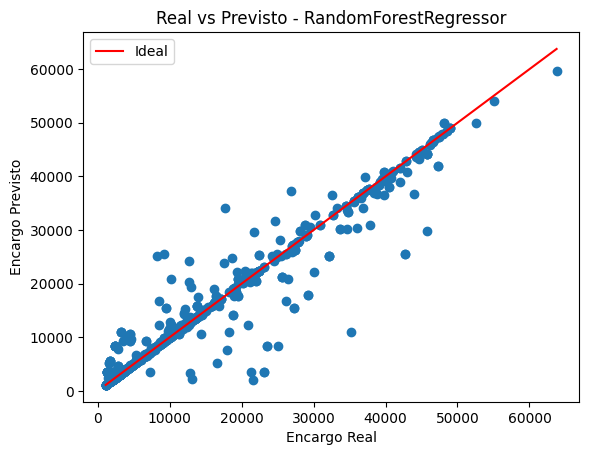

In [196]:
plt_real_previsto(y_test, y_pred, model)

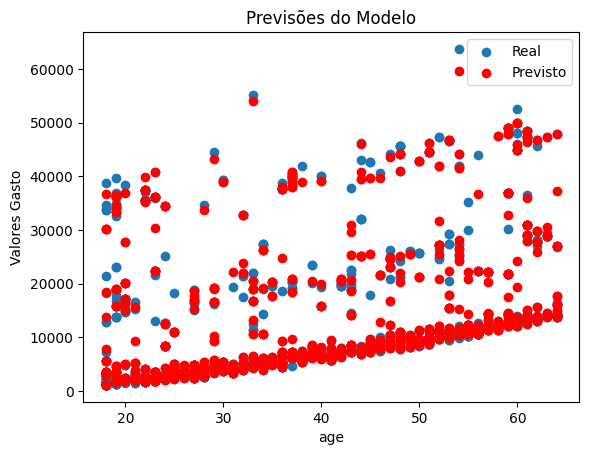

In [194]:
feature = 'age'

plt.scatter(X_test[feature], y_test, label='Real')
plt.scatter(X_test[feature], y_pred, label='Previsto', color='red')
plt.xlabel(feature)
plt.ylabel('Valores Gasto')
plt.title('Previsões do Modelo')
plt.legend()
plt.show()

# 4 - Modelo baseado em árvore (RandomForestRegressor) - - - - - - - - - - - - - -

In [25]:
from sklearn.ensemble import RandomForestRegressor

def radom_forest_regressor():
  model = RandomForestRegressor(n_estimators=100, random_state=42)

  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  # Avaliando o desempenho do modelo
  #avalia_modelo(rf, X_train, y_train, X_test, y_test, y_predito_random_forest)

  #validacao_cruzada(rf)
  return model, y_pred

**Run model random_tree_regressor**

In [35]:
X, y = define_x_y()

shuffle_split = True

X_train, y_train, X_test, y_test = process_split_train_test(X, y, shuffle_split)

model, y_pred = radom_forest_regressor()

avaliacao = avalia_modelo(model, X_train, y_train, X_test, y_test, y_pred)

df = pd.DataFrame([avaliacao])
df_results = pd.concat([df_results, df], ignore_index=True)
df_results.head(20)

Usando o ShuffleSplit em bmi-types
Avaliando o desempenho do modelo
mse - Mean Squared Error : 10090365.612666607
mae - Mean Absolute Error: 1160.275939432458
r2  - R-squared          : 0.9317285591189377

Validação cruzada k: 10
Desvio padrão do R²: 0.010081518300190143
Média do R²: 0.9772402032533825


,model,shuffle_split,upsampling,mae,mse,r2,k-fold std,k-fold mean
0,LinearRegression,False,False,4227.17,33916490.24,0.7815,0.057830,0.741254
1,DecisionTreeRegressor,True,False,3907.51,62678520.26,0.5845,0.046627,0.690190
2,DecisionTreeRegressor,False,False,3033.43,41847506.77,0.7304,0.046627,0.690190
3,RandomForestRegressor,False,False,2714.11,23108199.85,0.8512,0.040176,0.816638
4,RandomForestRegressor,True,False,4009.63,48655608.13,0.6774,0.040176,0.816638
5,LinearRegression,True,False,4100.91,42149780.10,0.7206,0.057830,0.741254
6,LinearRegression,True,False,4220.50,43254922.74,0.7271,0.018661,0.750707
7,LinearRegression,True,True,4268.50,42911644.32,0.7097,0.018778,0.741688
8,DecisionTreeRegressor,True,True,992.40,12132967.01,0.9179,0.010085,0.976300
9,RandomForestRegressor,True,True,1160.28,10090365.61,0.9317,0.010082,0.977240


**Resultado**

Com o modelo  **RandomForestRegressor** , usamos a primeiro a informação 'bmi' sem fazer a categorização obteve um resultado de **94,99%**. Após fizemos uma categorização na coluna '**bmi**' que obtivemos um resultado de **92,41%.** E depois usamos a técnica de **ShuffleSplit** para treinar o modelo nas faixas de BMI, onde tem uma melhora nos resultados **95,10%**

| bmi categories | ShuffleSplit | R-squared |
|---|---|---|
| Não | Não | 0.9512 |
| Sim | Não | 0.9366 |
| Sim | Sim | 0.9695 |


# Vizualizando as previsões

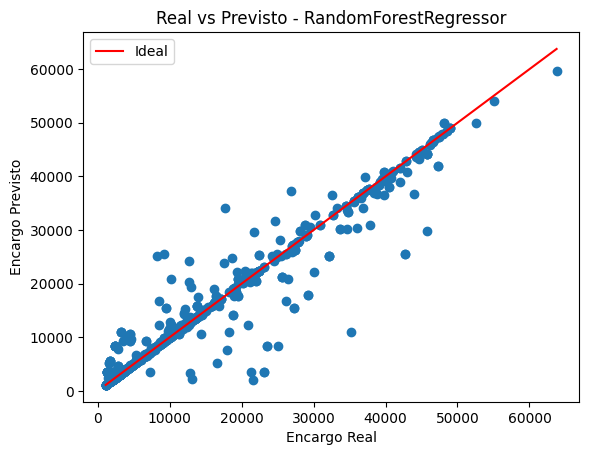

In [198]:
plt_real_previsto(y_test, y_pred, model)

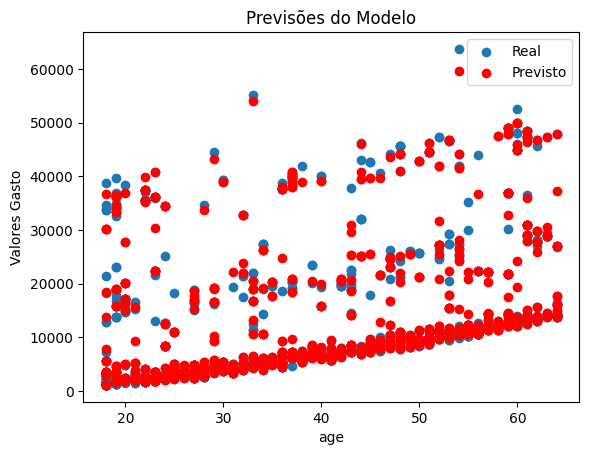

In [201]:
feature = 'age'

plt.scatter(X_test[feature], y_test, label='Real')
plt.scatter(X_test[feature], y_pred, label='Previsto', color='red')
plt.xlabel(feature)
plt.ylabel('Valores Gasto')
plt.title('Previsões do Modelo')
plt.legend()
plt.show()

# 4.3 - Usando StandardScaler

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #chamando o metodo de padronização dos dados (média e std)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

y_predito_random_forest_scaled = rf.predict(X_test_scaled)

avalia_modelo(rf, X_train_scaled, y_train, X_test_scaled, y_test, y_predito_random_forest_scaled)

Avaliando o desempenho do modelo
mse - Mean Squared Error : 48361647.32297641
mae - Mean Absolute Error: 3992.224045868407
r2  - R-squared          : 0.6793727902543457

O score nos dá uma visão da precisão média da floresta aleatória nos dados
score train:  0.9186030493979105
score test :  0.6793727902543457


**Obs:** Não há melhoras no modelo, usando StandardScaler